In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/ufcdata/preprocessed_data.csv
/kaggle/input/ufcdata/raw_fighter_details.csv
/kaggle/input/ufcdata/data.csv
/kaggle/input/ufcdata/raw_total_fight_data.csv


In [2]:
UFC = pd.read_csv('../input/ufcdata/data.csv')
UFC = UFC.dropna()
UFC_1 = UFC[['Winner','B_current_win_streak','R_current_win_streak', 'B_Reach_cms', 'R_Reach_cms', 'B_age', 'R_age']]
UFC_1.head(10)

,Winner,B_current_win_streak,R_current_win_streak,B_Reach_cms,R_Reach_cms,B_age,R_age
0,Red,4.0,4.0,170.18,162.56,31.0,32.0
1,Red,3.0,2.0,167.64,167.64,32.0,31.0
2,Red,3.0,11.0,185.42,193.04,36.0,35.0
3,Blue,4.0,0.0,170.18,172.72,26.0,29.0
4,Blue,1.0,0.0,185.42,190.50,32.0,26.0
6,Red,3.0,3.0,165.10,180.34,32.0,29.0
7,Blue,0.0,0.0,167.64,162.56,25.0,33.0
8,Blue,1.0,1.0,182.88,180.34,31.0,37.0
9,Red,1.0,3.0,162.56,160.02,34.0,29.0
10,Blue,0.0,0.0,187.96,200.66,28.0,28.0


Phase 1:

Prediction dimension: Result of fight for a fighter given:

1. Reach difference compared to opponent - as a factor of natural difference
2. Age difference compared opponent - as a factor of experience
3. Current win streak - as a factor of current form

The prediction dimension has three classes:
win (Yellow points),
loss (Purple points),
draw (Blue points)

In [3]:
UFC_red = pd.DataFrame()
UFC_red['reach_diff'] = UFC_1['R_Reach_cms'] - UFC_1['B_Reach_cms'] #reach difference
UFC_red['age_diff'] = UFC_1['R_age'] - UFC_1['B_age'] #age difference
UFC_red['current_win_streak'] = UFC_1['R_current_win_streak'] #current win streak
UFC_red.loc[UFC_1['Winner'] == 'Red', 'Result'] = 3 #'Win'
UFC_red.loc[UFC_1['Winner'] == 'Blue', 'Result'] = 1 #'Loss'
UFC_red.loc[UFC_1['Winner'] == 'Draw', 'Result'] = 2 #'Draw'
UFC_red.head(10)
UFC_red.describe()

,reach_diff,age_diff,current_win_streak,Result
count,3202.000000,3202.000000,3202.000000,3202.000000
mean,0.069806,0.372267,1.262961,2.275141
std,8.342072,5.210360,1.771427,0.953233
min,-30.480000,-17.000000,0.000000,1.000000
25%,-5.080000,-3.000000,0.000000,1.000000
50%,0.000000,0.000000,1.000000,3.000000
75%,5.080000,4.000000,2.000000,3.000000
max,30.480000,17.000000,16.000000,3.000000


In [4]:
UFC_blue = pd.DataFrame()
UFC_blue['reach_diff'] = UFC_1['B_Reach_cms'] - UFC_1['R_Reach_cms'] #reach difference
UFC_blue['age_diff'] = UFC_1['B_age'] - UFC_1['R_age'] #age difference
UFC_blue['current_win_streak'] = UFC_1['B_current_win_streak'] #current win streak
UFC_blue.loc[UFC_1['Winner'] == 'Blue', 'Result'] = 3 #'Win'
UFC_blue.loc[UFC_1['Winner'] == 'Red', 'Result'] = 1 #'Loss'
UFC_blue.loc[UFC_1['Winner'] == 'Draw', 'Result'] = 2 #'Draw'
UFC_blue.head(10)
UFC_blue.describe()

,reach_diff,age_diff,current_win_streak,Result
count,3202.000000,3202.000000,3202.000000,3202.000000
mean,-0.069806,-0.372267,1.175828,1.724859
std,8.342072,5.210360,1.433522,0.953233
min,-30.480000,-17.000000,0.000000,1.000000
25%,-5.080000,-4.000000,0.000000,1.000000
50%,0.000000,0.000000,1.000000,1.000000
75%,5.080000,3.000000,2.000000,3.000000
max,30.480000,17.000000,13.000000,3.000000


In [5]:
UFC_2 = pd.concat([UFC_blue,UFC_red])
UFC_2.head(10)
UFC_2.describe()

,reach_diff,age_diff,current_win_streak,Result
count,6.404000e+03,6404.000000,6404.000000,6404.000000
mean,-6.967846e-16,0.000000,1.219394,2.000000
std,8.341713e+00,5.223238,1.611819,0.992082
min,-3.048000e+01,-17.000000,0.000000,1.000000
25%,-5.080000e+00,-4.000000,0.000000,1.000000
50%,0.000000e+00,0.000000,1.000000,2.000000
75%,5.080000e+00,4.000000,2.000000,3.000000
max,3.048000e+01,17.000000,16.000000,3.000000


In [6]:
#current_win_streak is why we need to seperate out red/bue wins/losses
#this results in inverse point generation for reach_diff and age_diff
#we will predicting win or loss

In [7]:
#fig_1 = plt.figure()
#ax = fig_1.add_subplot(111)
#ax.scatter(UFC_2['reach_diff'], UFC_2['age_diff'], color='darkgreen', marker='.')
#plt.show()

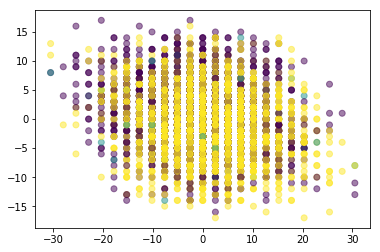

In [8]:
fig, ax = plt.subplots()
ax.scatter(UFC_2['reach_diff'], UFC_2['age_diff'], c=UFC_2['Result'], alpha=0.5)

#fig, (ax1, ax2) = plt.subplots(2)
#fig.suptitle('Vertically stacked subplots')
#ax1.scatter(UFC_2['reach_diff'], UFC_2['age_diff'], c=UFC_2['Result'])
#ax2.scatter(UFC_red['reach_diff'], UFC_red['age_diff'], c=UFC_red['Result'])

The yellow centre of this plot suggests an equal reach and age are better for a given fighter to win.

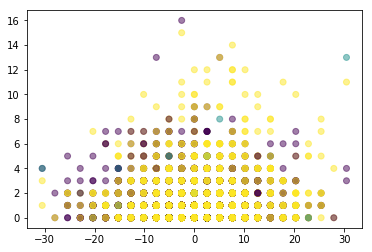

In [9]:
fig, ax = plt.subplots()
ax.scatter(UFC_2['reach_diff'], UFC_2['current_win_streak'], c=UFC_2['Result'], alpha=0.5)

The yellow cloud on the upper right of the plot suggest a greater reach and a win streak above 8 is favourable for a given fighter to win. The purple accumulation on the lower right suggests its not in a fighters favor to have a shorter reach.

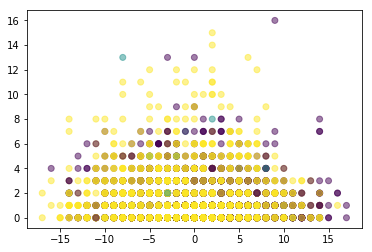

In [10]:
fig, ax = plt.subplots()
ax.scatter(UFC_2['age_diff'], UFC_2['current_win_streak'], c=UFC_2['Result'], alpha=0.5)

The purple tendancy on right of the plot suggest it is not in a fighters favor to have an older age difference.

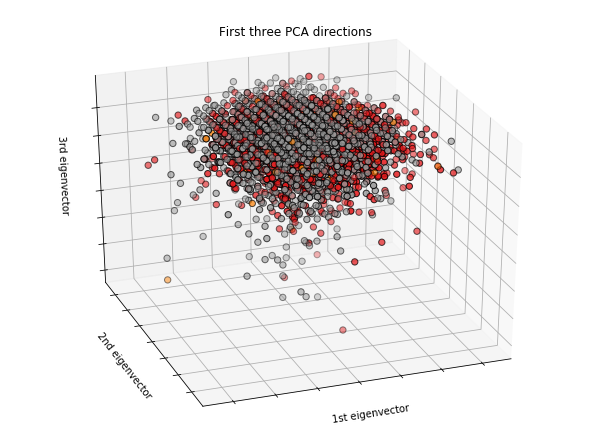

In [11]:
X = UFC_2[['reach_diff','age_diff','current_win_streak']]

#plot the first three PCA dimensions
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
X_reduced = PCA(n_components=3).fit_transform(X)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=UFC_2['Result'], cmap=plt.cm.Set1, edgecolor='k', s=40)
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

plt.show()

Phase 2+3:

The above PCA plot has not better defined regions of the latent dimension I had targeted, that being the classes of win/loss/draw. This suggests the dimensions I selected are not suitable predictors for this classification. As described above my selection of predictors sort to factorise concepts of natural and experiential differences as well current fighting form. Prehaps just selecting one concept and performing SVD on relevant dimensions to that concpet would define better boundaries on the win/loss/draw latent dimensions. The data original data also includes extensive technical data from fight such as body/head/ground strikes attempted and landed which intuitivily should produce better regionalised PCA plots given the human body has weak points.